# Error Analysis
#### ESE156 2020,  6th notebook, Christian Frankenberg 

Based on our previous "TCCON example", we will work through some linear error analysis here



In [39]:
# Use our tools (you might need to add packages, see file)
include("../scripts/ese156_tools.jl")

artifact_ESE_folder (generic function with 2 methods)

---
#### Define file and lat/lon

In [40]:
file = "../files/MERRA300.prod.assim.inst6_3d_ana_Nv.20150613.hdf.nc4"
timeIndex = 2 # There is 00, 06, 12 and 18 in UTC, i.e. 6 hourly data stacked together

# What latitude do we want? 
myLat = 34.1377;
myLon = -118.1253;

In [41]:
# Read profile (and generate dry/wet VCDs per layer)
profile_caltech_hr = read_atmos_profile(file, myLat, myLon, timeIndex);

---
#### Define HITRAN parameters

In [42]:
# Changed the limits here now: 

# Minimum wavenumber
ν_min  = 6280.0
# Maximum wavenumber
ν_xmax = 6420.0

co2_par = CrossSection.read_hitran("../files/hitran_molec_id_2_CO2.par", mol=2, iso=1, ν_min=ν_min, ν_max=ν_xmax);
ch4_par = CrossSection.read_hitran("../files/hitran_molec_id_6_CH4.par", mol=6, iso=1, ν_min=ν_min, ν_max=ν_xmax);
h2o_par = CrossSection.read_hitran("../files/hitran_molec_id_1_H2O.par", mol=1, iso=1, ν_min=ν_min, ν_max=ν_xmax);

In [43]:
co2_voigt   = make_hitran_model(co2_par, Voigt(), wing_cutoff=10)
h2o_voigt   = make_hitran_model(h2o_par, Voigt(), wing_cutoff=10)
ch4_voigt   = make_hitran_model(ch4_par, Voigt(), wing_cutoff=10)

hitran_array = [co2_voigt, h2o_voigt, ch4_voigt];

---
#### Define model resolution and compute all cross sections for profile

In [44]:
res = 0.005
ν = 6300:res:6400
σ_matrix_hr = compute_profile_crossSections(profile_caltech_hr, hitran_array , ν);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


In [45]:
# Reduce dimensions, group layers together to get roughly layers of equal pressure difference:
n_layers = 15
profile_caltech, σ_matrix = reduce_profile(n_layers, profile_caltech_hr, σ_matrix_hr);

In [46]:
# Define concentration profile:
#nL = length(profile_caltech.T)
nL = length(profile_caltech_hr.T)

vmr_co2 = zeros(nL) .+ 400e-6
vmr_ch4 = zeros(nL) .+ 2e-6
vmr_h2o = profile_caltech_hr.vcd_h2o ./ profile_caltech_hr.vcd_dry
vmrs = [vmr_co2, vmr_h2o, vmr_ch4 ];

# Define a polynomial scaling
p = Polynomial([2,-0.1,0.00003]);

---
### Define Instrument models:

In [47]:
# Define an Instrument, TCCON specs
FWHM = 0.02  # 0.2cm-1 resolution
Δν = 0.01
tccon = KernelInstrument(gaussian_kernel(FWHM, res), collect(6300:Δν:6400));

# Define an Instrument, OCO-2 specs
FWHM = 0.4  # 0.2cm-1 resolution
Δν = 0.1
oco2 = KernelInstrument(gaussian_kernel(FWHM, res), collect(6300:Δν:6400));

# Define an Instrument, SCIAMACHY specs
FWHM = 4.0  # 0.2cm-1 resolution
Δν = 1.0
sciamachy = KernelInstrument(gaussian_kernel(FWHM, res), collect(6300:Δν:6400));

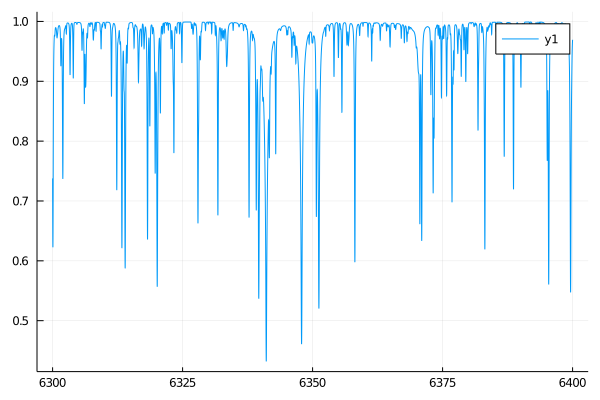

In [77]:
# Read in disk-centered solar spectrum:
sun = readdlm("../files/solar_merged_20160127_600_26316_100.out")
f_solar = CubicSplineInterpolation(sun[1,1]:sun[2,1]-sun[1,1]:sun[end,1], sun[:,2])
Tsolar = f_solar(ν)

plot(ν, Tsolar)

--- 
## How can we write this as a Forward Model F(x)?

First, we need to decide what we need in the state vector. If we assume that the temperature and pressure profile is well known, then these are "known" parameters and not part of the state vector. That probably leaves us with the polynomial term as well as the trace gas concentrations.

## Computing Forward model and Jacobian K
What we are trying to do now is to write a function that can evaluate the Forward model but also compute its Jacobian if needed. In principle, one could compute the Jacobian numerically but this would require evaluating the Forward model with a perturbed state vector (one for each) and choosing the right step-size to compute the derivative numerically 
$$\frac{\partial F(x)}{\partial x_i} = \frac{F(x+\Delta x_i)-F(x)}{\Delta x_i}$$
or better a two-point formula:
$$\frac{\partial F(x)}{\partial x_i} = \frac{F(x+\Delta x_i)-F(x-\Delta x_i)}{2\Delta x_i}$$

Let's go back to our forward model, which includes the computation of the transmission of the atmosphere along a slant light-path from the sun to the observer on the ground, multiplied with a low-order polynomial to account for any other effect such as scattering in the atmosphere, spectral shape of Black body of solar spectrum, detector sensitivity, etc. (it just bunches up all these effects without a real physical meaning here):
$$F(x) = <I_o\cdot\exp\left(-AMF\cdot\sum_{i=0}^n x_i\cdot VCD^{dryAir}_i\cdot \sigma_i(\nu)\right)\cdot \sum_{i=n+1}^{n+1+polyDegree}x_i\cdot \nu^{i-(n+1)}>$$ 
with $x_{i\dots n}$ being the the $VMRs$ and $x_{i+n\dots n+1+polyDegree}$ the coefficients for the polynomial. The operator $<>$ denotes the instrument operator (instrument line shape ILS), including the convolution of the high resolution transmission and resampling to the detector wavenumber grid:
$$<I>(\nu_1) = \int_{-\infty}^{\infty}I(\nu)\cdot ILS(\nu_1-\nu)d\nu$$
or in its discrete form
$$<I>(\nu_1) = \sum_{\nu=-\nu_1-\Delta}^{\nu_1+\Delta}I(\nu)\cdot ILS(\nu_1-\nu)\,,$$
where we can choose a width $\Delta$ over which the convolution will be applied (typically just the range over which the ILS is finite). The above didn't yet include the resampling to the detector ($y$) grid but this is just an interpolation anyhow (a down-sampling from a higher resolution grid to the actual nmeasurement grid). If the ILS is not changing over the entire fitting range, we can make use of the convolution theorem, which states that under suitable conditions the Fourier transform of a convolution is the pointwise product of Fourier transforms (otherwise, we often need a bute-force convolution, which can cost time). 

What we need to compute as well is the Jacobian Matrix $K$, which is defined as the derivative of the forward model with respect to $x$:

$$K = {dF(x) \over dx} = 
\left\vert\matrix{{\partial F_1(x) \over \partial x_1} & {\dots} & {\partial F_1(x) \over \partial x_n} \cr 
{\vdots} & {\ddots } & {\vdots} \cr 
{\partial F_m(x) \over \partial x_1} & {\dots} & {\partial F_m(x) \over \partial x_n}}\right\vert\,.$$

In our simplified forward model, we can actually compute the derivatives analytically. For the state vector elements with a $VMR$, the derivative will be:
$${\partial F(x) \over \partial x_i} = <F(x)\cdot -AMF \cdot VCD^{dryAir}_i\cdot \sigma_i(\nu)>$$

From here on, we will try to use Automatic Differentiation tools though (https://en.wikipedia.org/wiki/Automatic_differentiation).
Julia has tools for automatic differentation (even though you should be able to do this specific one still analytically without too much effort). However, there are current programming constraints, it has to be defined as single-valued functions (f(x); x=1D array) and return a 1D array), so let's try:



In [78]:
# Let's concatenate the important parameters as state vector:
# Make ABSOLUTELY sure you keep the order as in the σ_matrix!!
𝐱 = [vmr_co2; vmr_h2o; vmr_ch4; p[:] ];
@show size(𝐱)
sza = 45.0

size(𝐱) = (219,)


45.0

In [118]:
# and then rewrite the forward model:
function forward_model_x(𝐱     ;instrument=tccon, sza=sza, profile=profile_caltech_hr,σ_matrix=σ_matrix_hr, ν=ν, Tsolar=Tsolar)
    FT = eltype(𝐱);
    dims = size(σ_matrix)
    vmrs = reshape(𝐱[1:(dims[2]*dims[3])],(dims[2],dims[3]) )
    poly = Polynomial(𝐱[dims[2]*dims[3]+1:end])
    
    # Air Mass Factor
    AMF = 1/cosd(sza)
    
    # Total sum of τ
    ∑τ = zeros(FT,size(σ_matrix,1))
    for i=1:size(vmrs,2)
        ∑τ[:] += sum(σ_matrix[:,:,i] .* (vmrs[:,i] .* profile.vcd_dry)', dims=2)
    end
    # Transmission
    T = Tsolar .* exp.(-AMF * ∑τ)
    T_conv = conv_spectra(instrument, ν, T)
    # x-axis for polynomial [-1,1], enables legendre later:
    x_poly = rescale_x(instrument.ν_out)
    return T_conv .* poly.(x_poly)
end

forward_model_x (generic function with 1 method)

In [119]:
# Predefine output
result = DiffResults.JacobianResult(zeros(length(tccon.ν_out)),𝐱);

In [120]:
# Not yet happy about the speed here, likely due to a ton of allocations
@time ForwardDiff.jacobian!(result, forward_model_x, 𝐱 );

  7.151898 seconds (221.50 k allocations: 9.273 GiB, 11.96% gc time)


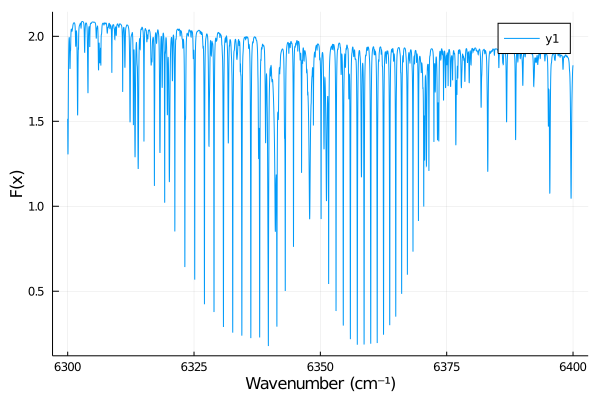

In [82]:
K = DiffResults.jacobian(result)
F = DiffResults.value(result)
plot(tccon.ν_out,F )
ylabel!("F(x)")
xlabel!("Wavenumber (cm⁻¹)")

--- 
#### Now let's think about the forward model close to the linearisation point (as this one here is non-linear)
$$ y = F(x) = F(x_a) + K\underbrace{(x-x_a)}_{x'}$$
$$ \underbrace{y-F(x_a)}_{y'} = Kx' $$
solve, then
$$ x = x'+x_a $$


In [83]:
𝐱a = [vmr_co2; vmr_h2o; vmr_ch4; p[:] ];
𝐱 = [vmr_co2; vmr_h2o; vmr_ch4; p[:] ];
ind_change = 62
𝐱[ind_change] = 0.0005
@show 𝐱[ind_change]
@show profile_caltech_hr.p[ind_change]/100

𝐱[ind_change] = 0.0005
profile_caltech_hr.p[ind_change] / 100 = 825.4167117813043


825.4167117813043

In [84]:
SNR   = 2000.0
noise = 2.0/SNR
y_xa  = forward_model_x(𝐱a);
ϵ  = noise * randn.(length(y_xa));
y_x   = forward_model_x(𝐱) .+ ϵ;

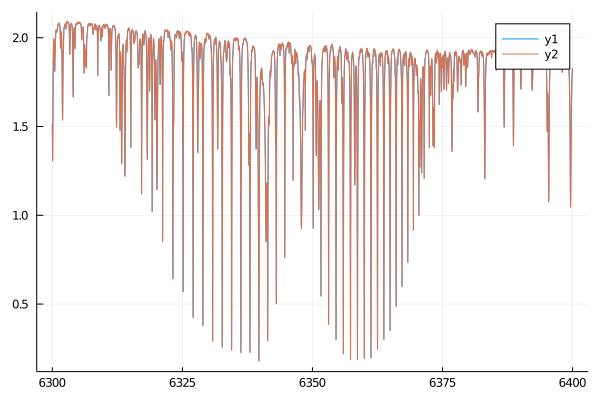

In [85]:
plot(tccon.ν_out, y_xa)
plot!(tccon.ν_out, y_x)
#xlims!(6322.8,6323.7)

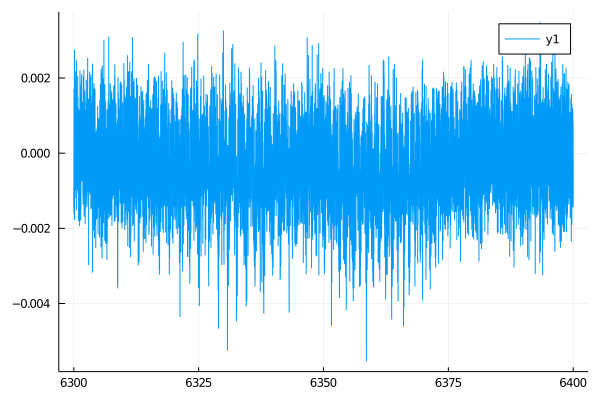

In [122]:
y_prime = y_x - y_xa;
plot(tccon.ν_out, y_prime)

In [87]:
# Get K evaluated at xa
@time ForwardDiff.jacobian!(result, forward_model_x, 𝐱a );
K = DiffResults.jacobian(result);

  6.694365 seconds (3.46 k allocations: 9.263 GiB, 12.00% gc time)


---
### Naive fitting

In [88]:
using LinearAlgebra
Se = Diagonal((ones(length(tccon.ν_out)).*noise).^2);

In [89]:
x_prime = inv(K'inv(Se)K)K'inv(Se)* y_prime;

In [92]:
x̂_naive = x_prime + 𝐱a;
@show nL

nL = 72


72

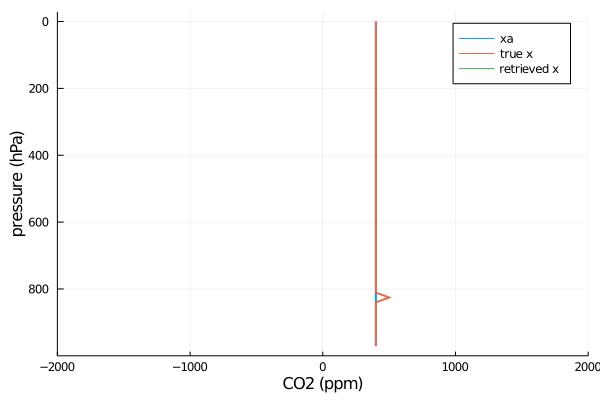

In [93]:
plot(𝐱a[1:nL]*1e6 ,profile_caltech_hr.p/100, yaxis=:flip, lw=2, label="xa")
plot!(𝐱[1:nL]*1e6 ,profile_caltech_hr.p/100, yaxis=:flip, lw=2, label="true x")
plot!(x̂_naive[1:nL]*1e6 ,profile_caltech_hr.p/100, yaxis=:flip, lw=2, label="retrieved x")
xlabel!("CO2 (ppm)")
ylabel!("pressure (hPa)")
xlims!(-2000,2000)

---
## Why is this so bad?
Ok, this simple inversion was really bad and messed up the retrieved state vector with many unphysical values. 

Why did this happen and how can we salvage this? The inversion is unstable (not enough information to solve the state vector) and we need to regularize the problem, a process of introducing additional information in order to solve an ill-posed problem or to prevent overfitting. There are different ways of doing this but for now, we will focus on using actual prior information and the Bayes Theorem (see Rodger's, pages 22ff):
$$P(x|y) = \frac{P(y|x)P(x)}{P(y)}$$

Using Gaussian uncertainties, we can express mismatches in the measurement space as well as the state vector space, if we assume some prior knowledge as to how the state vector "should" behave, characterized by it's prior $x_a$ (mean expected state) as well as its variance-covariance matrix $S_a$:
$$-2\ln P(y|x) = (y-Kx)^T S_{\epsilon}^{-1}(y-Kx)+c_1$$
and 
$$-2\ln P(x) =  (x-x_a)^T S_{a}^{-1}(x-x_a)+c_2\,,$$
with the prior covariance matrix $S_a$ representing the expected value 
$$S_a = \mathbf{E}\left((x-x_a)(x-x_a)^T\right)$$

If we assume $P(y)$ to just be a normalising factor, we can rewrite $-2\ln P(x|y)$ as
$$-2\ln P(x|y) = (y-Kx)^T S_{\epsilon}^{-1}(y-Kx) + (x-x_a)^T S_{a}^{-1}(x-x_a) + c_3$$

If we want to maximize $P(x|y)$, we just have to minimize the right hand side of the equation, which is almost exactly the same we found for the normal least squares approach apart from the added cost function induced by our prior knowledge: $(x-x_a)^T S_{a}^{-1}(x-x_a)$. 

As shown in Rodgers, the retrieved state vector $\hat{x}$ is now:
$$\hat{x} = x_a + (K^TS_\epsilon^{-1}K+S_a^{-1})^{-1}K^TS_\epsilon^{-1}(y-Kx_a)\,$$
for which we can replace $Kx_a$ with $F(x_a)$ as done in our case. 

What can we use as prior information for the CO$_2$ mixing ratio now? We know that it is a long-lived gas and its variations are rather small, with an overall seasonal amplitude of only 10-20ppm (around a background of 400ppm). We also know that changes in its concentrations are usually coorelated in between nearby atmospheric layers (vertically). So we could construct some covariance matrix based on a fixed relative errors on the diagonal but adding correlations on the off-diagonal (feel free to play around!). 

In the example below, we just assume a 10% uncertainty on the diagonal. Later, we could use variances on off-diagonal elements scaled with a exp(-corr_length * dp) factor, which provides a correlation as a function of pressure difference between layers (one could use real model data to try to generate a proper covariance matrix but here we use just this). 

In [94]:
n_state = length(𝐱a);
Sa = zeros(n_state,n_state);
rel_error = 0.25;
for i=1:3*nL
    Sa[i,i] = (rel_error*𝐱a[i])^2
end
for i=3*nL+1:n_state
    Sa[i,i] = 1e20;
end

---
## Computing Posterior error covariance, Gain matrix and Averaging Kernel:
We can compute the Gain matrix and posterior error covariance as before, just with $\hat{S}^{-1}$ now being
$$\hat{S}^{-1} = K^TS_\epsilon^{-1}K+S_a^{-1}\,$$
(see Rodgers).

We can also compute the Averaging Kernel Matrix $A$,
$$AK = {\partial \hat{x} \over \partial x} = GK$$
This can be seen as $\Delta F(x)$ is $K(x-x_a)+\epsilon$, thus
$$\hat{x} = G[K(x-x_a)+\epsilon] = GK(x-x_a)+G\epsilon$$

It is important to fully understand the meaning of the A matrix as it is instrumental in understanding the measurement sensitivity and later comparisons against model data (for instance). The A matrix (nxn) represents the derivative of the retrieved state vector $\hat{x}$ with respect to a true change in the state vector $x$. E.g. we can solve the question what would happen to the state vector if CO$_2$ in reality changes at only one layer at say 800hPa or 300hPa.
$$A = {\partial \hat{x} \over \partial x} = \left\vert\matrix{{\partial \hat{x}_1 \over \partial x_1} & {\dots} & {\partial \hat{x}_1 \over \partial x_n} \cr 
{\vdots} & {\ddots } & {\vdots} \cr 
{\partial \hat{x}_n \over \partial x_1} & {\dots} & {\partial \hat{x}_n \over \partial x_n}}\right\vert\,.$$

The rows of the $A$ basically show how a specific retrieved state vector element $\hat{x}_i$ reacts to true changes of the state vector at different positions $x_i$ while the columns of the $A$ show how the overal state vector $\hat{x}$ reacts to a perturbation of the true state in one singular position $x_i$. This is reflected in the columns of the $A$ while the rows reflect the change in the retrieved state vector at particular index $i$ vs. a change in the true state at all other positions. 
In the ideal case, the $A$ would be unity on the diagonal and zero elsewhere, indicating a perfect retrieval.

---

So, let's compute the posterior covariance matrix S^hat, the Gain Matrix G and the Averaging Kernel Matrix A

In [95]:
# Gain Matrix:
G = inv(K'inv(Se)K + inv(Sa))K'inv(Se)
# Averaging Kernel Matrix A
A = G*K;
Ŝ = inv(K'inv(Se)K + inv(Sa))
x_primeBayes = G * y_prime;
x̂_bayes = x_primeBayes + 𝐱a;

In [96]:
# Compute model response to noise vector
# Retrieval noise:
Geps = G*ϵ;

# Smoothing Error
A_smooth = (A-I)*(𝐱-𝐱a);


---
Let's look at averaging kernels:

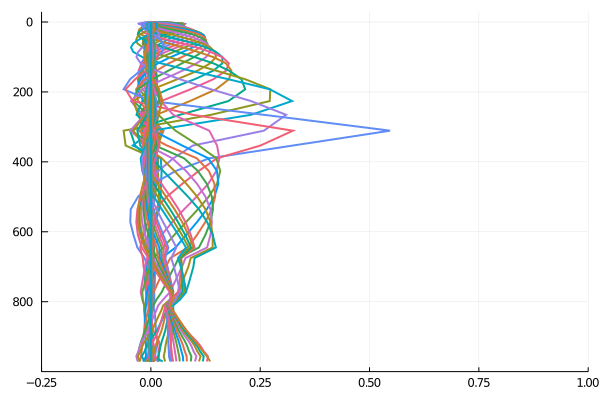

In [97]:
plot(A[1:nL,:],profile_caltech_hr.p/100, yaxis=:flip, lw=2, legend = false)
xlims!(-0.25,1)

These look a bit "wonky" but in our case, it has to do with the fact that the layers have different dry masses, let's normalize:

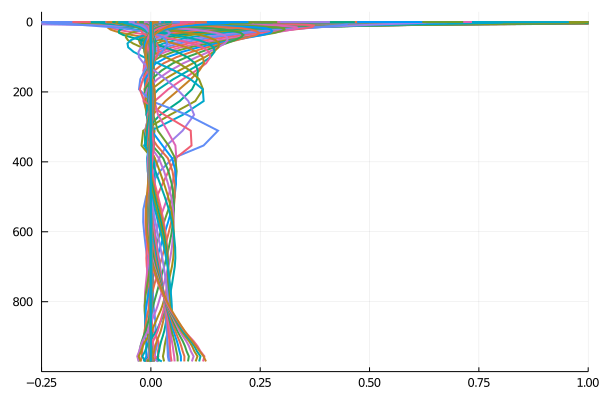

In [98]:
plot(A[1:nL,:]./profile_caltech_hr.vcd_dry * mean(profile_caltech_hr.vcd_dry),profile_caltech_hr.p/100, yaxis=:flip, lw=2, legend = false)
xlims!(-0.25,1)

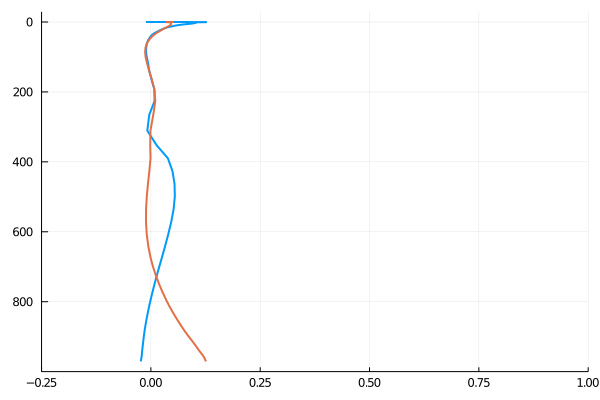

In [99]:
# Just plot a subset:
plot(A[1:nL,50]./profile_caltech_hr.vcd_dry * mean(profile_caltech_hr.vcd_dry),profile_caltech_hr.p/100, yaxis=:flip, lw=2, legend = false)
plot!(A[1:nL,nL]./profile_caltech_hr.vcd_dry * mean(profile_caltech_hr.vcd_dry),profile_caltech_hr.p/100, yaxis=:flip, lw=2, legend = false)
xlims!(-0.25,1)

### Error characterization:
Let's look at the impact of the smoothing error and retrieval noise.

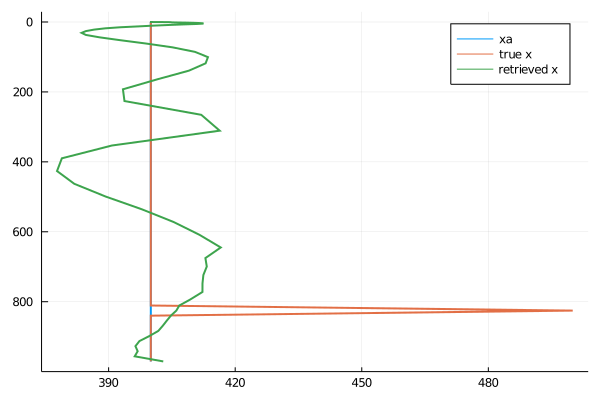

In [100]:
plot(𝐱a[1:nL]*1e6 ,profile_caltech_hr.p/100, yaxis=:flip, lw=2, label="xa")
plot!(𝐱[1:nL]*1e6 ,profile_caltech_hr.p/100, yaxis=:flip, lw=2, label="true x")
plot!((x̂_bayes[1:nL])*1e6 ,profile_caltech_hr.p/100, yaxis=:flip, lw=2, label="retrieved x")

---
Let's separate the error terms:

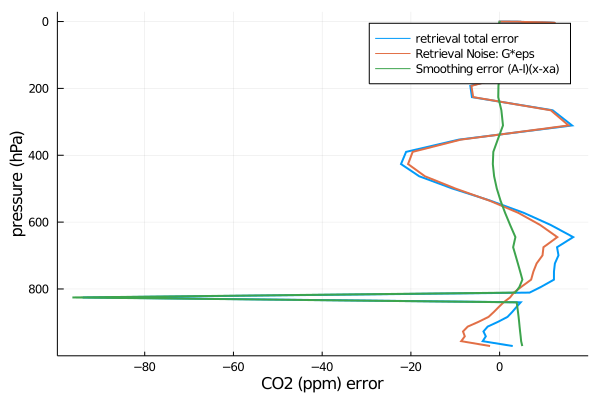

In [101]:
#plot(𝐱a[1:nL]*1e6 ,profile_caltech_hr.p/100, yaxis=:flip, lw=2, label="xa")
#plot!(𝐱[1:nL]*1e6 ,profile_caltech_hr.p/100, yaxis=:flip, lw=2, label="true x")
plot((x̂_bayes[1:nL]-𝐱[1:nL] )*1e6 ,profile_caltech_hr.p/100, yaxis=:flip, lw=2, label="retrieval total error")
plot!((G*ϵ)[1:nL]*1e6 ,profile_caltech_hr.p/100, yaxis=:flip, lw=2, label="Retrieval Noise: G*eps")
plot!( 1.e6*(A_smooth[1:nL]) ,profile_caltech_hr.p/100,lw=2, label="Smoothing error (A-I)(x-xa)")
#plot!( 1e6*(x̂_bayes[1:nL]-Geps[1:nL]),profile_caltech_hr.p/100,yflip=true,label="xhat - G*eps")
xlabel!("CO2 (ppm) error")
ylabel!("pressure (hPa)")

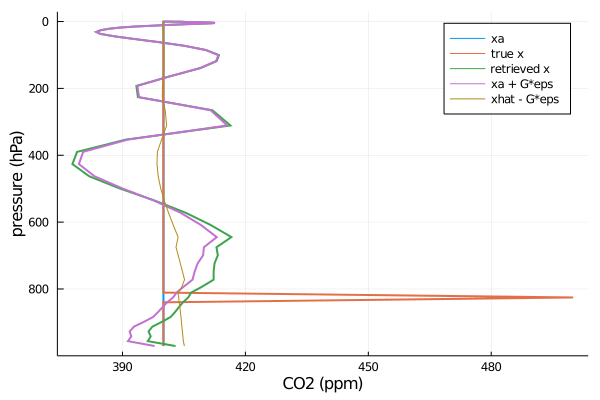

In [102]:
plot(𝐱a[1:nL]*1e6 ,profile_caltech_hr.p/100, yaxis=:flip, lw=2, label="xa")
plot!(𝐱[1:nL]*1e6 ,profile_caltech_hr.p/100, yaxis=:flip, lw=2, label="true x")
plot!(x̂_bayes[1:nL]*1e6 ,profile_caltech_hr.p/100, yaxis=:flip, lw=2, label="retrieved x")
plot!(𝐱a[1:nL]*1e6 + (G*ϵ)[1:nL]*1e6 ,profile_caltech_hr.p/100, yaxis=:flip, lw=2, label="xa + G*eps")
#plot!( 1.e6*(A_smooth[1:nL] + 𝐱a[1:nL]) ,profile_caltech_hr.p/100,lw=2, label="Smoothing error + xa")
plot!( 1e6*(x̂_bayes[1:nL]-Geps[1:nL]),profile_caltech_hr.p/100,yflip=true,label="xhat - G*eps")
xlabel!("CO2 (ppm)")
ylabel!("pressure (hPa)")

---
## Degrees of freedom for CO$_2$ profile
The degrees of freedom for signal (DOFs) is a metric for how many independent variables one can actually retrieve. It can be computed at the trace of the averaging kernel matrix. (see e.g. Rodgers, page 54 top)

Here, we can just look at the DOF for the CO2 retrievals (or the other trace gases). The is the trace of the averaging kernel matrix over the CO$_2$ state vector elements:

In [103]:
using Printf
# CO2
println("DOF for CO2: ", @sprintf "%1.1f" tr(A[1:nL,1:nL]))
# CH4
println("DOF for CH4: ", @sprintf "%1.1f" tr(A[nL+1:2nL,nL+1:2nL]))
# H2O
println("DOF for H2O: ", @sprintf "%1.1f" tr(A[2nL+1:3nL,2nL+1:3nL]))

# Entire state vector:
println("DOF for X: ",@sprintf "%1.1f" tr(A))

DOF for CO2: 6.9
DOF for CH4: 2.5
DOF for H2O: 0.0
DOF for X: 12.3


## Column averaging kernel

Often, we are not really interested in the entire state vector itself but derived properties using linear operators, for instance the column averaged mixing ratio of CO2, denoted as XCO2 (basically the column amount of CO2 divided by the column amount of dry air).

We can define an operator h, which let's us compute the column averaged mixing ratio from the state vector CO$_2$ elements.
$$XCO_2 = h^T\hat{x}$$
In our case, h is just the mass-weighted contribution of each layer to the total column. It is 
$$ h = VCD_{dry}/\sum{VCD_{dry}}$$

With the averaging kernel $A$ as described above, we can compute 
$$ \frac{\partial XCO_2}{\partial x_j} = (h^TA)_j$$

The column averaging kernel $cAK$ can then be computed as well, which is 
$$ cA_j = \frac{\partial XCO_2}{\partial XCO2_j} = \frac{\partial XCO_2}{\partial x_j \cdot h_j} = (h^TA)_j/h_j$$

And the variance in XCO$_2$ is given by 
$$\sigma^2(XCO_2) = h^T\hat{S}h$$

You can read up on random variables and transformations here: ftp://fluo.gps.caltech.edu/XYZT_ESE156/Reading/RandomVectors.pdf)

Assume you have a random variable vector $g$ (dimension P) with covariance $S_g$. If you convert $g$ into a new random variable vector $k$ (dimension Q) using the linear transform $M$ (a QxP matrix):
$$k = Mg\,,$$
then the covariance of $k$ ($S_k$) is 
$$S_k = MS_gM^T$$

You could use this equation for instance to proof that the error in the mean of uncorrelated errors goes down with $1/\sqrt(n)$ but not at all if errors are fully correlated. If you remember this one equation, it will remain very useful and is also the principle behind all the column averaging property calculations above for which we use the weighting function $h$ to convert a `n` dimensional random variable in the state vector to a 1D column averaged mixing ratio. 

Column averaging Operator for CO2:

In [104]:
h_co2 = zeros(length(𝐱))
h_co2[1:nL] = profile_caltech_hr.vcd_dry / sum(profile_caltech_hr.vcd_dry);

In [105]:
@show h_co2' * x̂_bayes * 1e6
@show h_co2' * 𝐱a      * 1e6
@show h_co2' * 𝐱       * 1e6
@show h_co2' * x̂_naive * 1e6

h_co2' * x̂_bayes * 1.0e6 = 401.45568939736387
h_co2' * 𝐱a * 1.0e6 = 400.0000000000001
h_co2' * 𝐱 * 1.0e6 = 401.4819828300416
h_co2' * x̂_naive * 1.0e6 = 1252.2315912359973


1252.2315912359973

In [106]:
@show sqrt(h_co2' * Sa * h_co2) * 1e6
@show sqrt(h_co2' * Ŝ  * h_co2) * 1e6

sqrt(h_co2' * Sa * h_co2) * 1.0e6 = 16.737573693572717
sqrt(h_co2' * Ŝ * h_co2) * 1.0e6 = 0.04922289409170938


0.04922289409170938

Column Averaging Kernel:

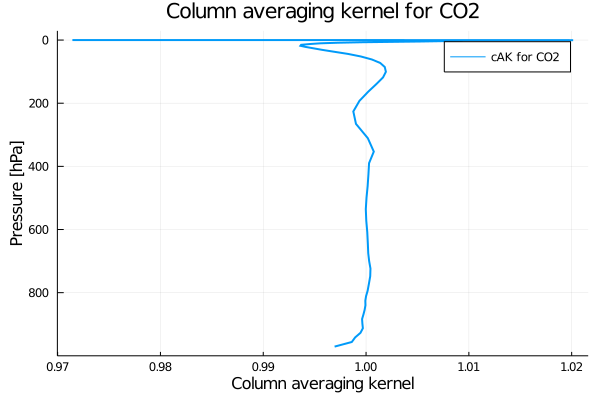

In [107]:
cK = (h_co2'*A)[1,:]./h_co2

plot(cK[1:nL],profile_caltech_hr.p/100,yflip=true,lw=2, label="cAK for CO2")

xlabel!("Column averaging kernel")
ylabel!("Pressure [hPa]")
title!("Column averaging kernel for CO2")

Let's change Sa to something different